In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.ops import unary_union
from shapely.geometry import LineString
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import LocalOutlierFactor


In [2]:

df_dict = {}

# Load data
for name in ['Village, GP coordinates', 'Railway', 'Imp Bridge, Ferry, etc']:
    df_dict[name] = gpd.read_file(f"shapefiles/{name}.shp")
    
# do some processing
df_dict['Village, GP coordinates'] = df_dict['Village, GP coordinates'].iloc[:1078]

# Get rid of outlier observations
df_dict['Village, GP coordinates'] = (
    df_dict['Village, GP coordinates']
    .assign(outlier = lambda df: LocalOutlierFactor(contamination=0.01)
            .fit_predict(df[["lat", "lon"]]))
    .query('outlier==1')
)
# Create spatial indices
df_dict['Village, GP coordinates'].sindex
df_dict['Railway'].sindex
df_dict['Imp Bridge, Ferry, etc'].sindex

rtree.index.Index(bounds=[88.13482233968274, 21.625555488832436, 88.984176997677, 22.66530546176495], size=111)

In [3]:
from shapely.geometry import LineString
import warnings
warnings.filterwarnings('ignore')

nearest_join_villages_to_railway = df_dict['Village, GP coordinates'].to_crs(
    epsg=3857).sjoin_nearest(df_dict['Railway'].to_crs(epsg=3857), distance_col='distance')

villages = df_dict['Village, GP coordinates'].to_crs(epsg=3857)
railways = df_dict['Railway'].to_crs(epsg=3857)

lines = gpd.GeoDataFrame()

lines = nearest_join_villages_to_railway.apply(lambda row: LineString([
    villages.loc[villages['Coordinate'] ==
                 row['Coordinate_left'], 'geometry'].centroid.values[0],
    railways.loc[railways['Coordinate'] ==
                 row['Coordinate_right'], 'geometry'].centroid.values[0]
]), axis=1).to_frame().rename({0: 'geometry'}, axis=1).pipe(gpd.GeoDataFrame, geometry='geometry')


NotImplementedError: Currently, only PyGEOS >= 0.10.0 supports `nearest_all`. To use PyGEOS within GeoPandas, you need to install PyGEOS: 'conda install pygeos' or 'pip install pygeos'

In [ ]:
# Now do the same for bridges
nearest_join_villages_to_bridge = df_dict['Village, GP coordinates'].to_crs(epsg=3857).sjoin_nearest(df_dict['Imp Bridge, Ferry, etc'].to_crs(epsg=3857), distance_col = 'distance')

bridges = df_dict['Imp Bridge, Ferry, etc'].to_crs(epsg=3857)

lines_bridges = (
    nearest_join_villages_to_bridge
    .apply(lambda row: LineString([
        villages.loc[villages['Coordinate']==row['Coordinate_left'], 'geometry'].centroid.values[0],
        bridges.loc[bridges['Coordinate']==row['Coordinate_right'], 'geometry'].centroid.values[0]
    ]), axis=1)
    .to_frame()
    .rename({0: 'geometry'}, axis=1)
    .pipe(gpd.GeoDataFrame, geometry='geometry')
)

In [ ]:
# Now we need distance to water
# The only way I can think of to do this is to load the sundarbans shapefile, dissolve it and then make its boundary a set of points

# Open shape file of sundarbans
sundarbans = gpd.read_file("GADM/gadm36_IND_3.shp").loc[lambda df: df['NAME_2'].isin(['South 24 Parganas', 'North 24 Parganas'])]
sundarbans_all = sundarbans.dissolve()

# What we can do now is clip the northwest so we only get points on the boundary with water. 
# We'll use the diamond harbor train stop and the Taki Road train stop as the line

diamond_harbor = railways.loc[lambda df: df['STATION/st']=='Diamond Harbour'].geometry.values[0]
taki_road = railways.loc[lambda df: df['STATION/st']=='Taki Road'].geometry.values[0]

# Actually as it turns out I need to elongate that line a bit
water_line = LineString([diamond_harbor, taki_road])

# now that we've dissolved it, set parameter `distance_delta` to get the number of points 
distance_delta = 0.05
distances = np.arange(0, sundarbans_all.boundary[0].length, distance_delta)

# Finally create points and take their union to get one object
points = [sundarbans_all.boundary[0].interpolate(distance) for distance in distances]
water_border = gpd.GeoDataFrame(geometry=points, crs="epsg:4326").reset_index()


In [ ]:
# Now do the same for water
nearest_join_villages_to_water = df_dict['Village, GP coordinates'].to_crs(epsg=3857).sjoin_nearest(water_border.to_crs(epsg=3857), distance_col = 'distance')

lines_water = (
    nearest_join_villages_to_water
    .apply(lambda row: LineString([
        villages.loc[villages['Coordinate'] == row['Coordinate'], 'geometry'].centroid.values[0],
        water_border.to_crs(epsg=3857).loc[water_border['index']==row['index'], 'geometry'].centroid.values[0]
    ]), axis=1)
    .to_frame()
    .rename({0: 'geometry'}, axis=1)
    .pipe(gpd.GeoDataFrame, geometry='geometry')
)

In [ ]:
## Merge together
columns_to_keep = ['District N', 'Sub-distri', 'Block Name', 'Local Body', 'Village Na', 'FD Study i', 'FD Study_1', 'geometry', 'distance']

distances = (nearest_join_villages_to_bridge[columns_to_keep]
 .rename({'distance' : 'distance_bridge'},axis=1)
 .merge(nearest_join_villages_to_railway
        .rename({'distance' : 'distance_railway'},axis=1)[['distance_railway', 'geometry']],
        on = 'geometry')
 .merge(nearest_join_villages_to_water
        .rename({'distance' : 'distance_water'},axis=1)[['distance_water', 'geometry']],
        on = ['geometry'],
        )
)

X = distances[['distance_bridge', 'distance_railway', 'distance_water']].values

blocks = pd.get_dummies(distances['Block Name'], drop_first=True).values

poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X = np.append(X, blocks, axis=1)

kmeans = KMeans(n_clusters=20, random_state=0).fit_predict(X)
kmeans8 = KMeans(n_clusters=8, random_state=0).fit_predict(X)
kmeans6 = KMeans(n_clusters=6, random_state=0).fit_predict(X)

distances  =distances.assign(kmeans = kmeans, kmeans8=kmeans8, kmeans6=kmeans6)

## Sundarbans Village Selection Map

The map looks messy now, but go to the top-right and untoggle some layers.

To make a particular village selection, put in a random seed and the village selection will change

In [ ]:
import folium
from ipywidgets import interact, IntText

# @interact(random_state = IntText())
def update_map(random_state):

    m = df_dict['Village, GP coordinates'].explore(tooltip='Village Na', name ='Villages', prefer_canvas=True)

    df_dict['Railway'].explore(m=m, color='red', name = 'Railways')

    df_dict['Imp Bridge, Ferry, etc'].explore(m=m, color='black', name = 'Bridges')

    lines.crs = "epsg:3857"
    lines_bridges.crs = "epsg:3857"
    lines_water.crs = "epsg:3857"

    lines.to_crs(epsg=4326).explore(m=m, color='orange', style_kwds = {'opacity' :0.3}, name = 'Distance to Railway')
    lines_bridges.to_crs(epsg=4326).explore(m=m, color='darkblue', style_kwds = {'opacity' :0.1}, name = 'Distance to Bridge')
    lines_water.to_crs(epsg=4326).explore(m=m, color='red', style_kwds = {'opacity' :0.1}, name = 'Distance to Water')

    water_border.to_crs(epsg=4326).explore(m=m, color='black', style_kwds = {'opacity' :0.1}, name = 'Water Border')

    distances.explore('kmeans6', name ="Kmeans6", m=m, categorical=True, marker_kwds = {'radius' : 4}, tooltip = 'Village Na')

    (
        df_dict['Village, GP coordinates']
        .loc[lambda df: df['FD Study_1']=='Yes']
        .explore(name  = '2018 Sample', m=m, 
                 color='green', marker_kwds = {'radius' : 7})
        )
    
    # Mark random sample villages
    # Make sure to choose villages that were in 2018-2019 sample

    # First get the number of villages and their cluster
    sample_n = (
        distances
        .loc[lambda df: df['FD Study_1']=='Yes']
        .groupby('kmeans6')
        .count()['Village Na']
        .reindex(distances['kmeans6'].unique())
        .fillna(0)
        )

    villages_selected = (
        distances
        .loc[lambda df: df['FD Study_1']!='Yes']
        .groupby(['kmeans6'])
        .apply(lambda grp: grp.sample(10 - int(sample_n[grp.name]), random_state = random_state)) # randomly only as many as we need
        .append(distances.loc[lambda df: df['FD Study_1']=='Yes'])
        .reset_index()
        .pipe(gpd.GeoDataFrame, geometry='geometry')
    )

    (
        villages_selected
        .explore('kmeans6', color='red', 
                name = 'Randomly Chosen Villages', 
                m=m, categorical=True, 
                marker_kwds = {'radius' : 8}, 
                tooltip = 'Village Na',
                )
    )

    folium.LayerControl().add_to(m)
    
    # Save to csv for download
    villages_selected.drop(['index', 'kmeans', 'kmeans8'], axis=1).to_csv("village-selection.csv")

    return m

update_map(1).save("map.html")

## Download Data

Here you can download the selected village data:

[Download](https://github.com/amichuda/sundarbans-livelihood-paper/blob/main/projects/fgd-village-selection/village-selection.csv)

## Appendix


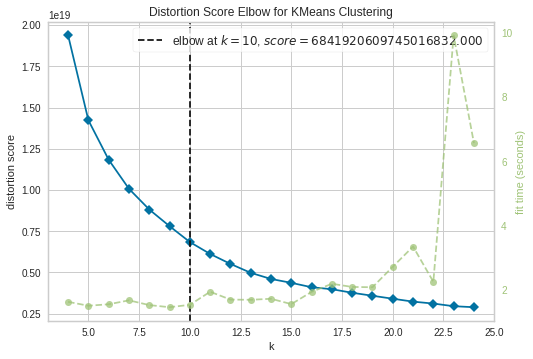

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(4,25))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

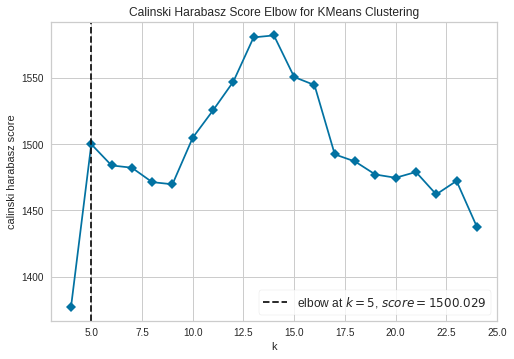

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [ ]:
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(4,25), metric='calinski_harabasz', timings=False)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure